# Bat Type and Hard Hit Rate, Zach Landry

Goal: Explore the data set and determine whether an adjustment is necessary to make the wood and metal bat data more directly comparable. In addition, we want to know if applying an adjustment to the data effectively strengthens the relationship between amateur and pro hard-hit rate.

## Initial Data Exploration and Preprocessing

First, we will load the necessary libraries to read the CSV file and examine the dataset, taking note of its shape and key features. 

In [1]:
# Import pandas library
import pandas as pd

# Read CSV data
df = pd.read_csv('NCAA_Hard_Hit_Data.csv')

df.shape

(38190, 20)

In [2]:
# Explore dataset features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38190 entries, 0 to 38189
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        38190 non-null  int64  
 1   id                38190 non-null  int64  
 2   batter_id         38190 non-null  int64  
 3   ama_start_year    38190 non-null  int64  
 4   ama_end_year      38190 non-null  int64  
 5   ama_pa            38190 non-null  int64  
 6   ama_bip           38190 non-null  int64  
 7   ama_hard_hit      35984 non-null  float64
 8   ama_chase_perc    37750 non-null  float64
 9   ama_sm_perc       37899 non-null  float64
 10  ama_exit_speed    35746 non-null  float64
 11  ama_launch_angle  35746 non-null  float64
 12  ama_gb_perc       35967 non-null  float64
 13  ama_fb_perc       35967 non-null  float64
 14  ama_ld_perc       35967 non-null  float64
 15  ama_oppo_perc     35967 non-null  float64
 16  ama_bat_type      38190 non-null  object

The dataset has 38,190 rows and 20 columns covering both amateur and some professional metrics, including the following variables of interest:
- `batter_id`: Unique batter ID
- `ama_hard_hit`: Amateur hard-hit rate
- `ama_bat_type`: Amateur bat type (metal vs. wood)
- `pro_hard_hit`: Professional hard-hit rate

These features, along with `ama_start_year`, `ama_end_year`, `ama_pa`, `ama_bip`, `pro_pa`, and `pro_bip`, are kept while the remaining columns are removed to reduce the dataset's dimensionality. 

In [3]:
# Make copy of original dataset before modifying
original_df = df.copy()

# Select relevant columns
df = df[['batter_id', 'ama_start_year', 'ama_end_year', 'ama_pa', 'ama_bip', 'ama_hard_hit', 'ama_bat_type', 'pro_pa', 'pro_bip', 'pro_hard_hit']]
df.head()

,batter_id,ama_start_year,ama_end_year,ama_pa,ama_bip,ama_hard_hit,ama_bat_type,pro_pa,pro_bip,pro_hard_hit
0,17,2015,2015,1,1,0.009492,Metal,NaN,NaN,NaN
1,228,2015,2015,40,29,0.281799,Metal,419.0,262.0,0.147152
2,242,2015,2015,27,17,0.165749,Metal,NaN,NaN,NaN
3,249,2015,2015,2,2,0.032220,Metal,NaN,NaN,NaN
4,338,2015,2015,2,1,0.071142,Metal,NaN,NaN,NaN


Since we want to analyze the effects of metal versus wood bats, batters that only have metal bat data are removed, leaving a set of 7,549 unique hitters who have played either professionally and/or in the Cape Cod League (CCL). 

In [4]:
# Filter hitters with both metal and wood bat data
df_both = df[
    (df['batter_id'].isin(df.groupby('batter_id')['ama_bat_type'].nunique()[lambda x: x > 1].index)) | 
    (df['pro_pa'] > 0)
]

total_hitters = df_both['batter_id'].nunique()
hitters_in_CCL = df_both[df_both['ama_bat_type'] == 'Wood']['batter_id'].nunique()
professional_hitters = df_both[df_both['pro_pa'] > 0]['batter_id'].nunique()
hitters_in_both = df_both[(df_both['pro_pa'] > 0) & (df_both['ama_bat_type'] == 'Wood')]['batter_id'].nunique()

print(f"Total Number of Hitters: {total_hitters}")
print(f"Number of Hitters who Played in CCL: {hitters_in_CCL}")
print(f"Number of Professional Hitters: {professional_hitters}")
print(f"Number of Hitters who Played Both: {hitters_in_both}")

Total Number of Hitters: 7549
Number of Hitters who Played in CCL: 6942
Number of Professional Hitters: 1613
Number of Hitters who Played Both: 1006


We see that 6,942 played in the CCL, 1,613 played professionally, and 1,006 played both professionally and in the CCL. 

In [5]:
df_both.head()

,batter_id,ama_start_year,ama_end_year,ama_pa,ama_bip,ama_hard_hit,ama_bat_type,pro_pa,pro_bip,pro_hard_hit
1,228,2015,2015,40,29,0.281799,Metal,419.0,262.0,0.147152
5,359,2015,2015,22,19,0.266103,Metal,1049.0,761.0,0.187540
7,411,2015,2015,22,14,0.281852,Metal,151.0,97.0,0.172410
26,976,2015,2015,10,8,0.322708,Metal,2.0,0.0,NaN
33,1156,2015,2015,32,18,0.241979,Metal,1118.0,730.0,0.246540


Furthermore, it's evident that many of the batters have limited plate appearances and balls in play (BIP). Assuming that hard-hit rate stabilizes after 50 balls in play, only batters that exceed this threshold with both wood and metal bats are kept in the dataset. This is accomplished by calculating the number of BIP with both types of bats for each player and creating a list of `batter_id` that satisfy the minimum threshold. For the sake of the analysis, any batters with null values or outliers for `ama_hard_hit` are removed. 

In [6]:
# Calculate balls in play (BIP) with metal and wood bats for each player
metal_bip_per_batter = df_both[df_both['ama_bat_type'] == 'Metal'].groupby('batter_id')['ama_bip'].sum()
wood_bip_per_batter = df_both[df_both['ama_bat_type'] == 'Wood'].groupby('batter_id')['ama_bip'].sum().add(df_both.groupby('batter_id')['pro_bip'].sum(), fill_value=0)

# Define minimum BIP
threshold = 50

# Merging list of batter_id who satisfy both conditions
batters_list = metal_bip_per_batter[metal_bip_per_batter >= threshold].index.intersection(wood_bip_per_batter[wood_bip_per_batter >= threshold].index).tolist()
print(f"Batters with at least {threshold} BIP: {len(batters_list)}")

# Returns True if all values are unique
print(f"All values unique: {len(batters_list) == len(set(batters_list))}")

# Filter dataset for "qualified" hitters
df_qualified = df_both[df_both['batter_id'].isin(batters_list)]

# Identify batters with null values in ama_hard_hit
null_batters = df_qualified[df_qualified['ama_hard_hit'].isnull()]['batter_id'].unique()

# Remove outliers using IQR
Q1 = df_qualified['ama_hard_hit'].quantile(0.25)
Q3 = df_qualified['ama_hard_hit'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify batters with outliers in ama_hard_hit
outlier_batters = df_qualified[(df_qualified['ama_hard_hit'] < lower_bound) | (df_qualified['ama_hard_hit'] > upper_bound)]['batter_id'].unique()

# Combine the two sets of batter IDs to remove
batters_to_remove = set(null_batters).union(outlier_batters)

# Filter out these batters from df_qualified
df_qualified = df_qualified[~df_qualified['batter_id'].isin(batters_to_remove)]

print(f"Number of batters after preprocessing: {df_qualified['batter_id'].nunique()}")

Batters with at least 50 BIP: 2157
All values unique: True
Number of batters after preprocessing: 2152


In [7]:
df_qualified['ama_bat_type'].value_counts()

ama_bat_type
Metal    2152
Wood     1924
Name: count, dtype: int64

Of the 2,152 batters with at least 50 BIP, 1,924 used wood bats in the CCL, and 228 used wood bats only in pro ball. To compare hard-hit rate differences between metal and wood bats, we will plot a histogram of hard-hit rate distributions for `ama_bat_type`.

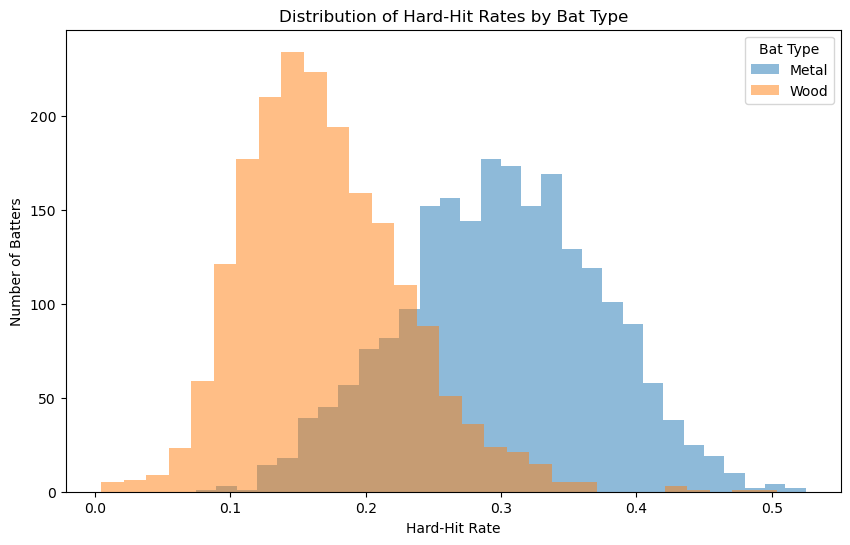

In [8]:
# Import plotting library
import matplotlib.pyplot as plt

# Split data by bat type
metal_hh = df_qualified[df_qualified['ama_bat_type'] == 'Metal']['ama_hard_hit']
wood_hh = df_qualified[df_qualified['ama_bat_type'] == 'Wood']['ama_hard_hit']

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(metal_hh.dropna(), bins=30, alpha=0.5, label='Metal') # drop missing values
plt.hist(wood_hh.dropna(), bins=30, alpha=0.5, label='Wood') # drop missing values
plt.xlabel("Hard-Hit Rate")
plt.ylabel("Number of Batters")
plt.title("Distribution of Hard-Hit Rates by Bat Type")
plt.legend(title="Bat Type")
plt.show()

In [9]:
# Hard-hit rate summary statistics for each bat type
summary_stats = pd.DataFrame({
    'Metal Bat': metal_hh.describe(),
    'Wood Bat': wood_hh.describe()
})
print(summary_stats)

         Metal Bat     Wood Bat
count  2152.000000  1924.000000
mean      0.300230     0.170195
std       0.072932     0.060298
min       0.074552     0.004474
25%       0.250808     0.127893
50%       0.300937     0.163035
75%       0.350260     0.206739
max       0.525017     0.504106


The summary statistics and histogram point to a distinct difference in hard-hit rates between metal and wood bats. On average, players achieve a higher hard-hit rate with metal bats with a mean rate of 0.30 compared to 0.17 for wood bats. The median values (0.30 for metal bats and 0.16 for wood) reinforce this difference, suggesting that metal bats may facilitate harder contact more easily than wood bats.

Looking at the range and variability of hard-hit rates, metal bats show a more consistent pattern across players. Metal bat hard-hit rates range from 0.073 to 0.525, with a standard deviation of 0.073. In contrast, wood bats display a broader range, from as low as 0.004 to 0.504, though with a slightly smaller standard deviation of 0.060. The lower minimum, broader range, and lower standard deviation suggest that wood bats yield less variable results on average, but require increased bat-to-ball skills to generate power with a smaller, less forgiving sweet spot.  

The percentile values provide further insight into the consistency gap between bat types. For metal bats, the 25th, 50th, and 75th percentiles are 0.25, 0.30, and 0.35, respectively, whereas for wood bats, these percentiles are considerably lower at 0.13, 0.16, and 0.21. This pattern suggests that even players who do not hit exceptionally well tend to see a boost in hard-hit rates with metal bats, while wood bats appear to accentuate performance differences, possibly penalizing less skilled hitters more.

## Statistical Analysis

We will perform a two-sample t-test to examine whether there is a statistically significant difference in the mean hard-hit rate between metal and wood bats. The data must satisfy the following assumptions:
- **Normality**: From the above histograms, the distributions of hard-hit rates for each bat type appear approximately normal. Given the large sample sizes of each group, the Central Limit Theorem satisfies the normal distribution condition.
- **Independence**: Each row represents a unique batter/season combination, so the observations in each group are independent.
- **Equal Variance**: A two-sample t-test typically assumes equal variance between groups, but we will perform a Levene's test to assess variance equality and adjust the t-test accordingly.

In [10]:
from scipy.stats import ttest_ind, levene

# Perform Levene's test to check equal variances
levene_stat, p_value = levene(metal_hh, wood_hh)

print(f"P-Value: {p_value}")

P-Value: 9.697299055119717e-21


The Levene's Test reveals a p-value of virtually zero, indicating unequal variances. Therefore, we will proceed with a Welch's t-test.

In [11]:
# Welch's t-test
t_stat, p_value = ttest_ind(metal_hh, wood_hh, equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 62.26533839070797
P-value: 0.0


The results of the t-test show overwhelming evidence that there is a difference in mean hard-hit rates, and we can conclude that there needs to be an adjustment to the data is necessary. Before doing this, we will first calculate the correlation between the amateur and professional hard-hit rates to establish a baseline.  

In [12]:
# Calculate correlation between amateur and pro hard-hit rates
cor = df_qualified[['ama_hard_hit', 'pro_hard_hit']].corr().iloc[0,1]
print(f"Baseline Correlation: {cor}")

Baseline Correlation: 0.35936618062596065


## Adjustment Methods

### Scaling Factor
The first adjustment we can make to the wood and metal bat data is applying a scaling factor to account for the observed difference in mean hard-hit rates. Since metal bats generally produce higher hard-hit rates, the aim is to scale these rates to a level more representative of wood bat performance. This scaling factor will be calculated by dividing the mean hard-hit rate with metal bats by the mean hard-hit rate with wood bats.  

In [13]:
# Calculate scaling factor
scaling_factor = metal_hh.mean() / wood_hh.mean()

# Apply to dataset to create new adjusted column
df_qualified['adj_scaling_ama_hard_hit'] = df_qualified.apply(lambda x: x['ama_hard_hit'] / scaling_factor if x['ama_bat_type'] == 'Metal' else x['ama_hard_hit'], axis=1)

A new column `adj_scaling_ama_hard_hit` represents the hard-hit rates after scaling the hard-hit rates with metal bats. As seen in the histograms below, the distribution of the adjusted metal hard-hit rates are more similar to the distribution of hard-hit rates with wood bats. 

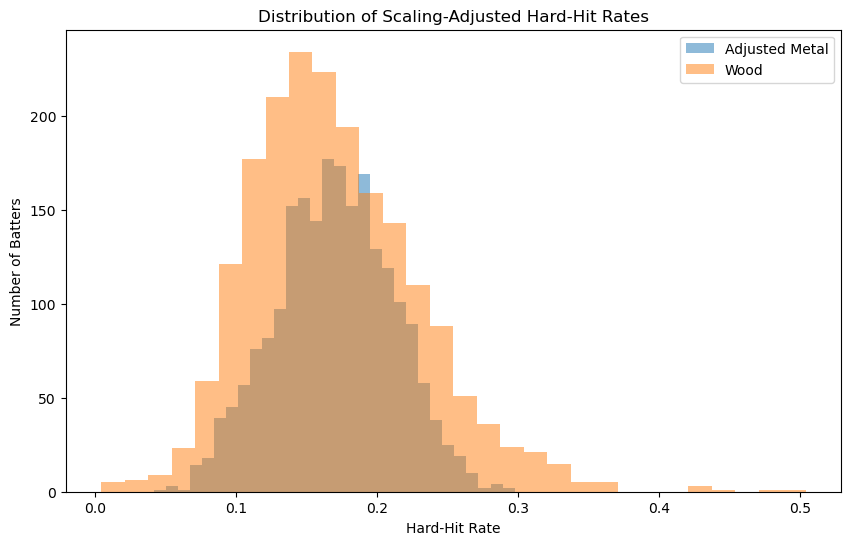

In [14]:
# Isolate adjusted hard-hit rate
adj_scaling = df_qualified[df_qualified['ama_bat_type'] == 'Metal']['adj_scaling_ama_hard_hit']

# Plot distribution of adjusted hard-hit rates and wood-bat hard hit rate
plt.figure(figsize=(10, 6))
plt.hist(adj_scaling.dropna(), bins=30, alpha=0.5, label='Adjusted Metal') # drop missing values
plt.hist(wood_hh.dropna(), bins=30, alpha=0.5, label='Wood') # drop missing values
plt.xlabel("Hard-Hit Rate")
plt.ylabel("Number of Batters")
plt.title("Distribution of Scaling-Adjusted Hard-Hit Rates")
plt.legend()
plt.show()

We will analyze the effectiveness of this adjustment by seeing if it improves the correlation between amateur and pro hard-hit rates. 

In [15]:
# Calculate correlation between pro hard-hit rates and scaling-adjusted amateur hard-hit rates
adj_scaling_cor = df_qualified[['adj_scaling_ama_hard_hit', 'pro_hard_hit']].corr().iloc[0,1]
print(f"Scaling Factor Adjusted Correlation: {adj_scaling_cor}")
print(f"Difference from Original Correlation: {adj_scaling_cor - cor}")

Scaling Factor Adjusted Correlation: 0.5026216481745968
Difference from Original Correlation: 0.1432554675486361


Scaling the metal bat hard-hit rates using the factor derived from their mean difference enhanced the correlation by approximately 0.14. While this is a notable improvement, we will try other adjustment methods to see if we can further improve this correlation. 

### Regression 
A regression-based adjustment applies a linear regression model to account for the impact of bat type on amateur hard-hit rates, aiming to create a closer alignment with professional hard-hit rates. This approach begins by encoding bat type as a binary variable – 1 to metal bats and 0 to wood bats. Next, we fit a linear regression model with amateur hard-hit rate and bat type as predictor variables and professional hard-hit rate as the target. Through this, the model learns the influence of amateur hard-hit rates on professional performance, taking into account the effect of bat type. Once trained, the model generates "professional-equivalent" predictions for amateur hard-hit rates, hopefully making amateur data more directly comparable to professional data.

In [16]:
# Create binary variable for bat type
df_qualified['bat_type'] = df_qualified['ama_bat_type'].apply(lambda x: 1 if x == 'Metal' else 0)

# Import linear regression library
import statsmodels.api as sm

# Initialize and fit Linear Regression model
regression_data = df_qualified[['ama_hard_hit', 'bat_type', 'pro_hard_hit']].dropna()

# Add a constant to the predictor variables to include an intercept
X = sm.add_constant(regression_data[['ama_hard_hit', 'bat_type']])
y = regression_data['pro_hard_hit']

# Fit the model using statsmodels' OLS (Ordinary Least Squares) method
model = sm.OLS(y, X).fit()

# Print the summary output
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           pro_hard_hit   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     336.7
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.31e-123
Time:                        15:46:22   Log-Likelihood:                 2696.8
No. Observations:                1676   AIC:                            -5388.
Df Residuals:                    1673   BIC:                            -5371.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1720      0.004     48.655   

The model indicates that amateur hard-hit rate is a strong predictor of professional hard-hit performance, with higher amateur rates correlating positively with higher professional rates. The bat type variable reveals that players using metal bats tend to experience a reduction in professional hard-hit rate, likely due to performance differences when transitioning from metal to wood bats. 

We can create regression-adjusted values for amateur hard-hit rates by using the model's regression equation. We will then plot the distribution of these values compared to the wood-bat values before calculating their correlation with pro hard-hit rates.

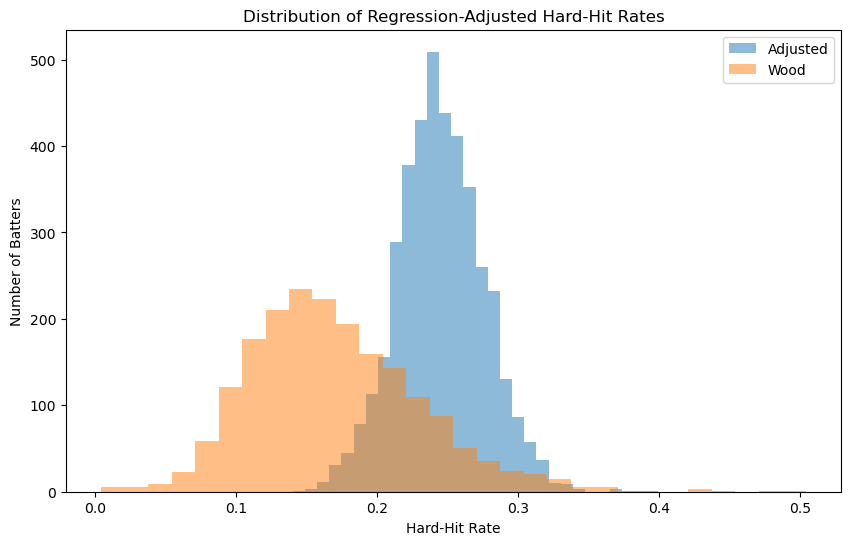

In [17]:
# Calculate regression-adjusted values for amateur hard-hit rates
df_qualified['adj_regression_ama_hard_hit'] = model.params[0] + (model.params[1]*df_qualified['ama_hard_hit']) + (model.params[2]*df_qualified['bat_type'])

# Isolate adjusted hard-hit rate
adj_regression = df_qualified['adj_regression_ama_hard_hit']

# Plot distribution of adjusted hard-hit rates and wood-bat hard hit rate
plt.figure(figsize=(10, 6))
plt.hist(adj_regression.dropna(), bins=30, alpha=0.5, label='Adjusted') # drop missing values
plt.hist(wood_hh.dropna(), bins=30, alpha=0.5, label='Wood') # drop missing values
plt.xlabel('Hard-Hit Rate')
plt.ylabel('Number of Batters')
plt.title('Distribution of Regression-Adjusted Hard-Hit Rates')
plt.legend()
plt.show()

In [18]:
# Calculate correlation betweem regression-adjusted amateur hard-hit rates and pro hard-hit rates
adj_regression_cor = df_qualified[['adj_regression_ama_hard_hit', 'pro_hard_hit']].corr().iloc[0,1]
print(f"Regression Adjusted Correlation: {adj_regression_cor}")
print(f"Difference from Original Correlation: {adj_regression_cor - cor}")

Regression Adjusted Correlation: 0.5357071379916906
Difference from Original Correlation: 0.1763409573657299


Interestingly, the distribution of the regression-adjusted rates doesn't have as much overlap with the distribution of the wood-bat rates as the scaled rates. The correlation to pro hard-hit rates (~0.54), however, is stronger by several points, suggesting the regression-based adjustment is more effective in making the metal and wood bat more directly comparable. 

### Z-Score Normalization

This normalization approach will be used to standardize amateur hard-hit rates for players using metal and wood bats, ideally making the two sets directly comparable. This adjustment is particularly beneficial since the two groups have different means and variances, as it removes these differences by converting each data point into a standardized score. The core assumption behind Z-score normalization is that relative performance within each group (metal vs. wood) is more important than absolute values, meaning that players’ hard-hit rates can be compared based on their standing within their respective bat-type group.

To calculate z-score normalization, each player’s amateur hard-hit rate is subtracted by the mean and then divided by the standard deviation of their bat type group, resulting in a standardized hard-hit rate centered around zero with a standard deviation of one for each bat type.

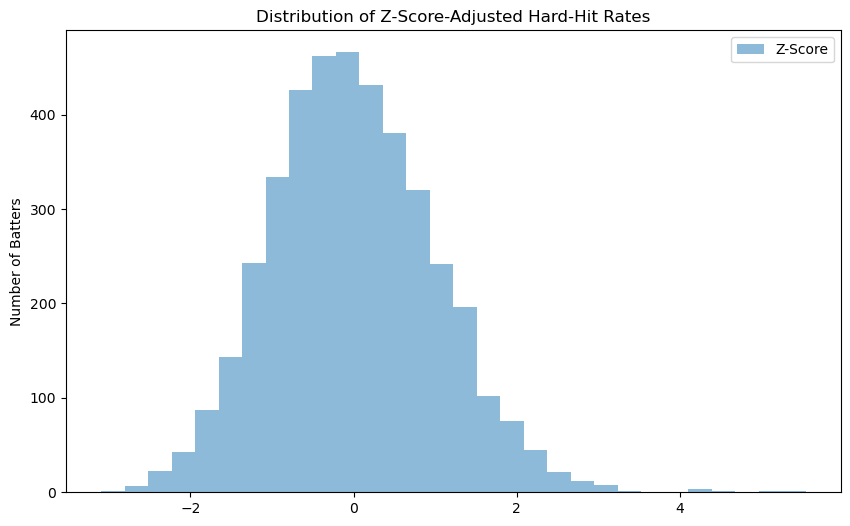

In [19]:
# Calculate mean and standard deviation for each bat type
metal_mean = df_qualified[df_qualified['bat_type'] == 1]['ama_hard_hit'].mean()
metal_std = df_qualified[df_qualified['bat_type'] == 1]['ama_hard_hit'].std()

wood_mean = df_qualified[df_qualified['bat_type'] == 0]['ama_hard_hit'].mean()
wood_std = df_qualified[df_qualified['bat_type'] == 0]['ama_hard_hit'].std()

# Apply Z-score normalization based on bat type
df_qualified['adj_zscore_ama_hard_hit'] = df_qualified.apply(lambda x: (x['ama_hard_hit'] - metal_mean) / metal_std if x['bat_type'] == 1 else (x['ama_hard_hit'] - wood_mean) / wood_std, axis=1)

# Isolate z-score-adjusted hard-hit rate
adj_zscore = df_qualified['adj_zscore_ama_hard_hit']

# Plot distribution of adjusted hard-hit rates and wood-bat hard hit rate
plt.figure(figsize=(10, 6))
plt.hist(adj_zscore.dropna(), bins=30, alpha=0.5, label='Z-Score') # drop missing values
plt.ylabel("Number of Batters")
plt.title("Distribution of Z-Score-Adjusted Hard-Hit Rates")
plt.legend()
plt.show()

In [20]:
# Standardize pro_hard_hit across to compare to amateur z-scores
pro_mean = df_qualified['pro_hard_hit'].mean()
pro_std = df_qualified['pro_hard_hit'].std()
df_qualified['pro_hard_hit_z'] = (df_qualified['pro_hard_hit'] - pro_mean) / pro_std

# Calculate correlation betweem z-score-adjusted amateur hard-hit rates and pro hard-hit rates
adj_zscore_cor = df_qualified[['adj_zscore_ama_hard_hit', 'pro_hard_hit_z']].corr().iloc[0,1]
print(f"Z-Score Adjusted Correlation: {adj_zscore_cor}")
print(f"Difference from Original Correlation: {adj_zscore_cor - cor}")

Z-Score Adjusted Correlation: 0.5269962577960644
Difference from Original Correlation: 0.16763007717010375


Looking at the distribution of z-scores, it appears to appropriately standardize the values for each bat type. In order to calculate its correlation to pro hard-hit rate, we need to standardize these values as well. After computing the z-scores for `pro_hard_hit`, we see that the correlation is better than the baseline, but sligtly lower than the regression-based method. 

## Final Thoughts

In this analysis, we explored scaling, regression, and z-score normalization adjustments to make amateur hard-hit rates from metal and wood bats comparable. Below are the final correlations between the adjusted amateur hard-hit rates and pro hard-hit rates, along with the unadjusted correlation for comparison:

In [21]:
print(f"Baseline Correlation: {cor.round(2)}")
print(f"Scaling Factor Adjusted Correlation: {adj_scaling_cor.round(2)}")
print(f"Regression Adjusted Correlation: {adj_regression_cor.round(2)}")
print(f"Z-Score Adjusted Correlation: {adj_zscore_cor.round(2)}")

Baseline Correlation: 0.36
Scaling Factor Adjusted Correlation: 0.5
Regression Adjusted Correlation: 0.54
Z-Score Adjusted Correlation: 0.53


Each method showed varying degrees of effectiveness, with regression achieving the highest correlation to professional hard-hit rates. This suggests a stronger alignment when modeling the amateur-to-pro transition with regression adjustments, making it an ideal candidate for adjusting amateur data for draft evaluations. Additional features contributing to hard-hit balls, such as bat speed or barrel accuracy, could be included in the regression model to improve its accuracy and correlation to pro-ball data. 

However, if simplicity and interpretability are prioritized, scaling remains effective for improving correlations and standardizing amateur hard-hit rates. Rather than creating a scaling factor based on the mean difference in hard-hit rates, the difference in coefficient of restitution or another more scientific measurement may provide a more accurate and comparable values. Integrating these adjustments into the draft model will offer a more accurate and robust prediction of amateur players' professional performance potential.

This comprehensive approach provides a foundation for integrating bat type adjustments into player evaluations, supporting more data-driven decision-making in amateur scouting.